In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

### **종목 선정 모델 개발**

이번절에서는 책에서 종목선정을 위해 사용할 GAM 모델을 개발하겠습니다. 아나콘다에서 제공하지 않으므로 아나콘다 프롬프트에서 conda install -c conda-forge pygam 로 설치를 해 줍니다. 
pip install pygam 으로 설치를 해도 됩니다. 관련 링크 https://anaconda.org/conda-forge/pygam

모델링을 위해 준비한 데이터를 읽습니다. 그리고 모델의 오버피팅을 최소화하기 위하여 타겟변수를 0 과 1 로 치환합니다. 5% 익절은 데이터로 표현하면 다음과 같습니다 - 'max_close' 가 5% 이상일 때 1, 아니면 0. 'max_close' 가 1 인 비율을 보니, 약 24% 입니다. 5000 개 샘플을 뽑아 예측모델을 만들고 나머지로 데이터로 테스트(혹은 백테스팅)를 하겠습니다. 

In [2]:
feature_all = pd.read_pickle('feature_all.pkl') 
feature_all['target'] = np.where(feature_all['max_close']>= 1.05, 1, 0)
target = feature_all['target'].mean()
print(f'% of target:{target: 5.1%}')

% of target: 24.2%


In [50]:
mdl_all = feature_all.drop(columns=['max_close', 'sector']).set_index([feature_all.index,'code'])

train = mdl_all.sample(10000, random_state=124)
test = mdl_all.loc[~mdl_all.index.isin(train.index)]

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10000 entries, (Timestamp('2021-10-28 00:00:00'), '036800') to (Timestamp('2021-11-05 00:00:00'), '298540')
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_z             10000 non-null  float64
 1   volume_z            10000 non-null  float64
 2   num_high/close      10000 non-null  float64
 3   num_long            10000 non-null  float64
 4   num_z>1.96          10000 non-null  float64
 5   num_win_market      10000 non-null  float64
 6   pct_win_market      10000 non-null  float64
 7   return over sector  10000 non-null  float64
dtypes: float64(8)
memory usage: 717.0+ KB


In [60]:
from pygam import LogisticGAM, s, f, te, l

X = train.drop(columns='target')
y = train['target']
X_test = test.drop(columns='target')
y_test = test['target']

gam = LogisticGAM(te(0,1, n_splines=5) + s(1) + s(2) + f(3) + l(4) + s(5) + s(6) + s(7), verbose=True)
results = gam.gridsearch(X.to_numpy(), y.to_numpy())
print(results.summary())


100% (11 of 11) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     24.0452
Link Function:                        LogitLink Log Likelihood:                                 -5396.6872
Number of Samples:                        10000 AIC:                                            10841.4647
                                                AICc:                                           10841.5955
                                                UBRE:                                               3.0861
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0225
Feature Function                  Lam

<Figure size 432x288 with 0 Axes>

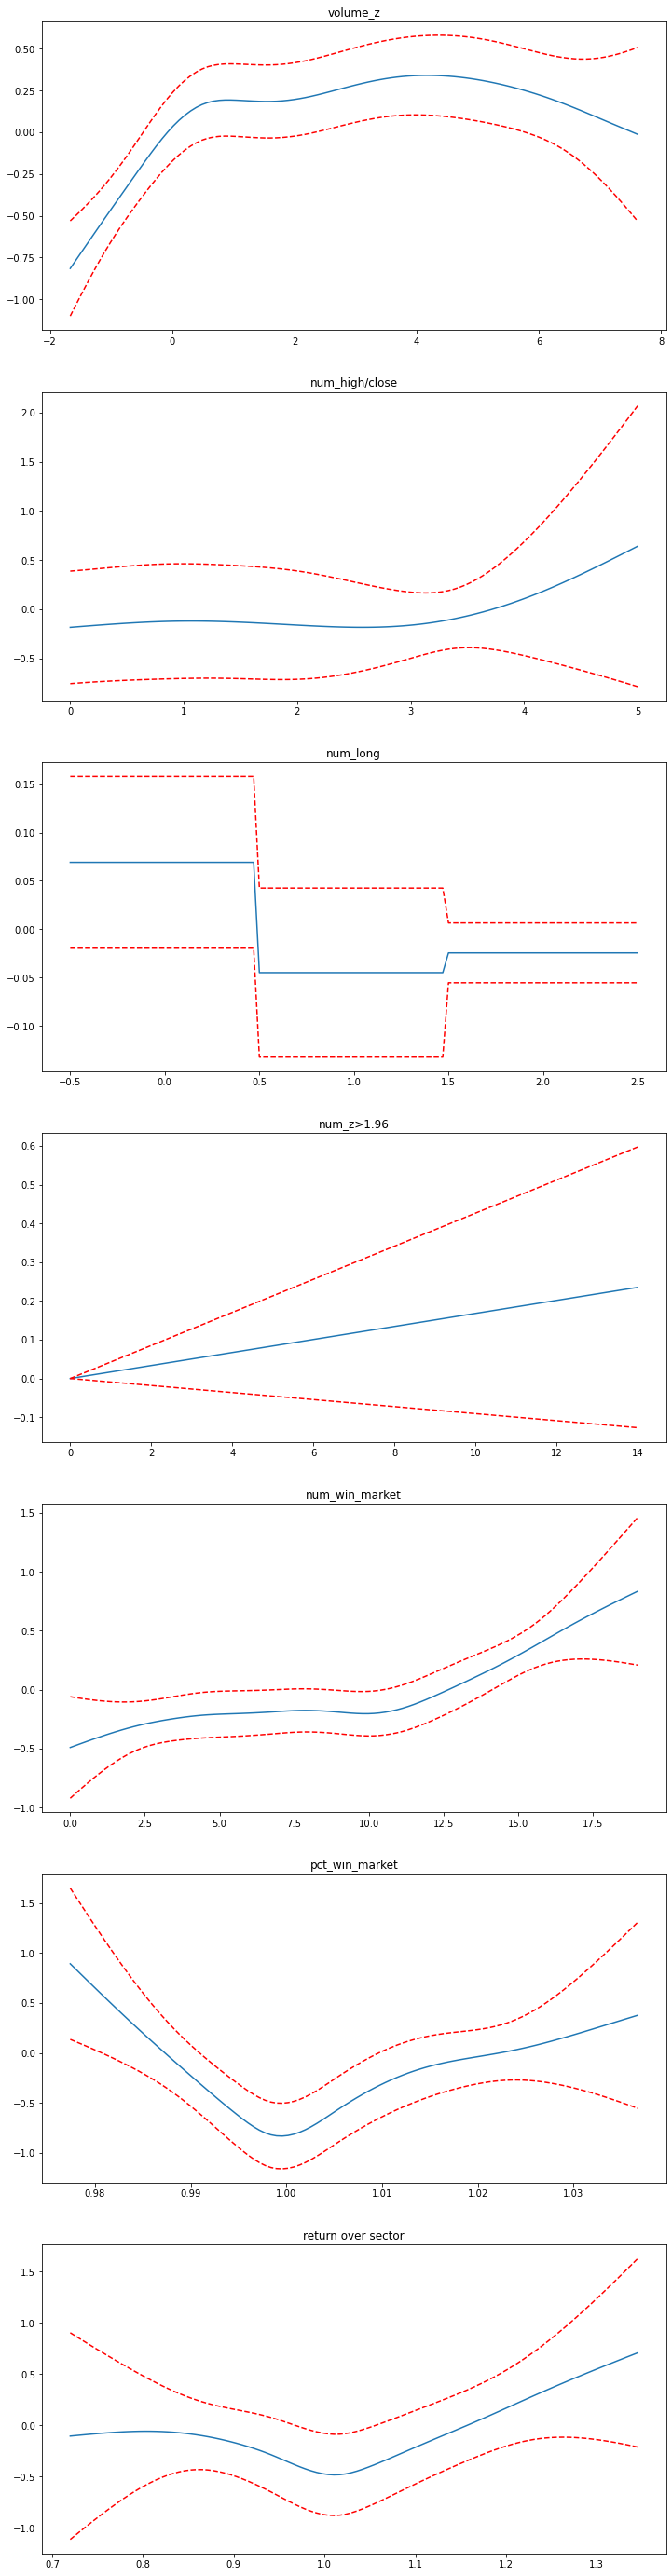

In [68]:
titles = list(train.columns)
plt.figure()
fig, axs = plt.subplots(7, 1, figsize=(12, 50))
for i, ax in enumerate(axs):
    i = i + 1
    XX = gam.generate_X_grid(term=i)

    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,  width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

In [69]:
yhat = results.predict_proba(X.to_numpy())
yhat = pd.Series(yhat, name='yhat', index=y.index)

yhat_test = results.predict_proba(X_test.to_numpy())
yhat_test = pd.Series(yhat_test, name='yhat', index=y_test.index)

                count  mean
yhat                       
(0.103, 0.178]   1000 0.181
(0.178, 0.195]   1000 0.164
(0.195, 0.207]   1000 0.193
(0.207, 0.218]   1000 0.209
(0.218, 0.228]   1000 0.191
(0.228, 0.24]    1000 0.248
(0.24, 0.255]    1000 0.228
(0.255, 0.275]   1000 0.284
(0.275, 0.314]   1000 0.304
(0.314, 0.745]   1000 0.407
                              count  mean
yhat                                     
(0.07289999999999999, 0.178]  29255 0.164
(0.178, 0.195]                29254 0.184
(0.195, 0.207]                29254 0.190
(0.207, 0.218]                29255 0.201
(0.218, 0.228]                29254 0.218
(0.228, 0.24]                 29254 0.237
(0.24, 0.255]                 29255 0.254
(0.255, 0.275]                29254 0.284
(0.275, 0.312]                29254 0.316
(0.312, 0.914]                29255 0.367


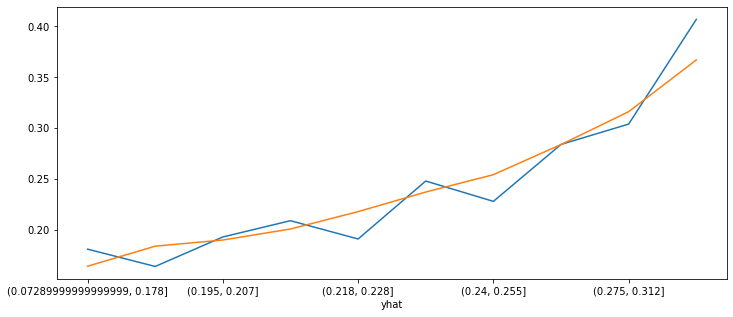

In [70]:
def perf(y, yhat): # Decile 분석 함수
    combined = pd.concat([y, yhat], axis=1)
    ranks = pd.qcut(combined['yhat'], q=10)
    print(combined.groupby(ranks)['target'].agg(['count','mean']))
    combined.groupby(ranks)['target'].mean().plot(figsize=(12,5))

perf(y, yhat)
perf(y_test, yhat_test)